In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=200 # Number of kernels in convolutional network
kernel_size1=3
strides=1
n_units=256 # Number of units in the hidden layer of the MLP network
input_size = 100 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating input dataset - mask
mask_dir = main_directory + '\\aeroCNN2Mask'
os.chdir(mask_dir)
mask_list = os.listdir(mask_dir)
mask_target = [file for file in mask_list if file.endswith('.csv')]

In [8]:
mask_df = pd.DataFrame()
for file in mask_target:
    data = pd.read_csv(file, header=None)
    mask_df = pd.concat([mask_df, data], axis=0)

In [9]:
x = mask_df.iloc[:,:].values

In [10]:
x_alligned = np.zeros((x.shape[0],x.shape[1]))
for i in range(0,144*2):
    if i%2==0:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:]
    else:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:].T


In [11]:
x = x_alligned.reshape((16*9,2,input_size,input_size))

In [12]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]
os.chdir(main_directory)

In [13]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [14]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [15]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [16]:
y.shape

(144, 2)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [18]:
x_train.shape

(100, 2, 100, 100)

In [19]:
y_train.shape

(100, 2)

In [20]:
tf.keras.backend.set_image_data_format('channels_first')

In [22]:
input_image = tf.keras.Input(shape=(2, input_size, input_size))

x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_flat = tf.keras.layers.Flatten()(x_)
x_fc1 = tf.keras.layers.Dense(units=16, activation='relu', name='fc1')(x_flat)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc1)
# AeroCNN-II based
model = tf.keras.Model(input_image, output_data)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 100, 100)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 200, 100, 100)     3800      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 200, 50, 50)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 500000)            0         
                                                                 
 fc1 (Dense)                 (None, 16)                8000016   
                                                                 
 outputLayer (Dense)         (None, 2)                 34        
                                                             

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [26]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [27]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 9s 54ms/step - loss: 2050.2671 - rmse: 45.2799 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 17ms/step - loss: 106.8888 - rmse: 10.3387 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 17ms/step - loss: 0.8505 - rmse: 0.9222 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.7831 - rmse: 0.8849 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.7834 - rmse: 0.8851 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.7836 - rmse: 0.8852 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.7835 - rmse: 0.8852 - lr: 0.0010
Epoch 8/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.7834 - rmse: 0.8851 - lr: 0.0010
Epoch 9/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.7832 - rmse: 0.8850 - lr: 0.0010
Epoch 10/5000
5/5 [====

5/5 [==============================] - 0s 13ms/step - loss: 0.7348 - rmse: 0.8572 - lr: 0.0010
Epoch 77/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.7338 - rmse: 0.8566 - lr: 0.0010
Epoch 78/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.7328 - rmse: 0.8560 - lr: 0.0010
Epoch 79/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.7318 - rmse: 0.8554 - lr: 0.0010
Epoch 80/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.7308 - rmse: 0.8548 - lr: 0.0010
Epoch 81/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.7297 - rmse: 0.8542 - lr: 0.0010
Epoch 82/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.7287 - rmse: 0.8536 - lr: 0.0010
Epoch 83/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.7277 - rmse: 0.8530 - lr: 0.0010
Epoch 84/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.7266 - rmse: 0.8524 - lr: 0.0010
Epoch 85/5000
5/5 [==============

5/5 [==============================] - 0s 13ms/step - loss: 0.6482 - rmse: 0.8051 - lr: 0.0010
Epoch 151/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.6469 - rmse: 0.8043 - lr: 0.0010
Epoch 152/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.6456 - rmse: 0.8035 - lr: 0.0010
Epoch 153/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.6443 - rmse: 0.8027 - lr: 0.0010
Epoch 154/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.6430 - rmse: 0.8019 - lr: 0.0010
Epoch 155/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.6417 - rmse: 0.8010 - lr: 0.0010
Epoch 156/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.6403 - rmse: 0.8002 - lr: 0.0010
Epoch 157/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.6390 - rmse: 0.7994 - lr: 0.0010
Epoch 158/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.6377 - rmse: 0.7986 - lr: 0.0010
Epoch 159/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.5472 - rmse: 0.7397 - lr: 0.0010
Epoch 225/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.5458 - rmse: 0.7388 - lr: 0.0010
Epoch 226/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.5444 - rmse: 0.7378 - lr: 0.0010
Epoch 227/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.5430 - rmse: 0.7369 - lr: 0.0010
Epoch 228/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.5416 - rmse: 0.7359 - lr: 0.0010
Epoch 229/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.5402 - rmse: 0.7350 - lr: 0.0010
Epoch 230/5000
5/5 [==============================] - 0s 14ms/step - loss: 0.5388 - rmse: 0.7340 - lr: 0.0010
Epoch 231/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.5374 - rmse: 0.7331 - lr: 0.0010
Epoch 232/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.5360 - rmse: 0.7321 - lr: 0.0010
Epoch 233/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.4452 - rmse: 0.6673 - lr: 0.0010
Epoch 299/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.4439 - rmse: 0.6663 - lr: 0.0010
Epoch 300/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.4426 - rmse: 0.6652 - lr: 0.0010
Epoch 301/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.4413 - rmse: 0.6643 - lr: 0.0010
Epoch 302/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.4399 - rmse: 0.6633 - lr: 0.0010
Epoch 303/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.4386 - rmse: 0.6623 - lr: 0.0010
Epoch 304/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.4372 - rmse: 0.6612 - lr: 0.0010
Epoch 305/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.4359 - rmse: 0.6603 - lr: 0.0010
Epoch 306/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.4346 - rmse: 0.6592 - lr: 0.0010
Epoch 307/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.3523 - rmse: 0.5936 - lr: 0.0010
Epoch 373/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.3511 - rmse: 0.5926 - lr: 0.0010
Epoch 374/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.3500 - rmse: 0.5916 - lr: 0.0010
Epoch 375/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.3489 - rmse: 0.5907 - lr: 0.0010
Epoch 376/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.3477 - rmse: 0.5896 - lr: 0.0010
Epoch 377/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.3465 - rmse: 0.5886 - lr: 0.0010
Epoch 378/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.3453 - rmse: 0.5877 - lr: 0.0010
Epoch 379/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.3443 - rmse: 0.5867 - lr: 0.0010
Epoch 380/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.3431 - rmse: 0.5857 - lr: 0.0010
Epoch 381/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.2747 - rmse: 0.5241 - lr: 0.0010
Epoch 447/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.2738 - rmse: 0.5233 - lr: 0.0010
Epoch 448/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2729 - rmse: 0.5224 - lr: 0.0010
Epoch 449/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2720 - rmse: 0.5215 - lr: 0.0010
Epoch 450/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2711 - rmse: 0.5206 - lr: 0.0010
Epoch 451/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2702 - rmse: 0.5198 - lr: 0.0010
Epoch 452/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2692 - rmse: 0.5189 - lr: 0.0010
Epoch 453/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2683 - rmse: 0.5180 - lr: 0.0010
Epoch 454/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2674 - rmse: 0.5171 - lr: 0.0010
Epoch 455/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.2154 - rmse: 0.4641 - lr: 0.0010
Epoch 521/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2147 - rmse: 0.4634 - lr: 0.0010
Epoch 522/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2141 - rmse: 0.4627 - lr: 0.0010
Epoch 523/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2134 - rmse: 0.4619 - lr: 0.0010
Epoch 524/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2127 - rmse: 0.4612 - lr: 0.0010
Epoch 525/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2121 - rmse: 0.4605 - lr: 0.0010
Epoch 526/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2114 - rmse: 0.4598 - lr: 0.0010
Epoch 527/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.2107 - rmse: 0.4591 - lr: 0.0010
Epoch 528/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.2101 - rmse: 0.4584 - lr: 0.0010
Epoch 529/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.1741 - rmse: 0.4173 - lr: 0.0010
Epoch 595/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1737 - rmse: 0.4167 - lr: 0.0010
Epoch 596/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1732 - rmse: 0.4162 - lr: 0.0010
Epoch 597/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1728 - rmse: 0.4156 - lr: 0.0010
Epoch 598/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1723 - rmse: 0.4151 - lr: 0.0010
Epoch 599/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1719 - rmse: 0.4146 - lr: 0.0010
Epoch 600/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1715 - rmse: 0.4141 - lr: 0.0010
Epoch 601/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1710 - rmse: 0.4136 - lr: 0.0010
Epoch 602/5000
5/5 [==============================] - 0s 14ms/step - loss: 0.1706 - rmse: 0.4131 - lr: 0.0010
Epoch 603/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.1482 - rmse: 0.3850 - lr: 0.0010
Epoch 669/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1480 - rmse: 0.3847 - lr: 0.0010
Epoch 670/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1478 - rmse: 0.3844 - lr: 0.0010
Epoch 671/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1475 - rmse: 0.3840 - lr: 0.0010
Epoch 672/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1472 - rmse: 0.3837 - lr: 0.0010
Epoch 673/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.1470 - rmse: 0.3834 - lr: 0.0010
Epoch 674/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1467 - rmse: 0.3831 - lr: 0.0010
Epoch 675/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1465 - rmse: 0.3827 - lr: 0.0010
Epoch 676/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1462 - rmse: 0.3824 - lr: 0.0010
Epoch 677/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.1340 - rmse: 0.3661 - lr: 0.0010
Epoch 743/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1339 - rmse: 0.3659 - lr: 0.0010
Epoch 744/5000
5/5 [==============================] - 0s 14ms/step - loss: 0.1337 - rmse: 0.3657 - lr: 0.0010
Epoch 745/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1336 - rmse: 0.3655 - lr: 0.0010
Epoch 746/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1335 - rmse: 0.3653 - lr: 0.0010
Epoch 747/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1334 - rmse: 0.3652 - lr: 0.0010
Epoch 748/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1332 - rmse: 0.3650 - lr: 0.0010
Epoch 749/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1331 - rmse: 0.3648 - lr: 0.0010
Epoch 750/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1330 - rmse: 0.3646 - lr: 0.0010
Epoch 751/5000
5/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 0.1273 - rmse: 0.3567 - lr: 0.0010
Epoch 817/5000
5/5 [==============================] - 0s 14ms/step - loss: 0.1272 - rmse: 0.3566 - lr: 0.0010
Epoch 818/5000
5/5 [==============================] - 0s 14ms/step - loss: 0.1271 - rmse: 0.3565 - lr: 0.0010
Epoch 819/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1271 - rmse: 0.3565 - lr: 0.0010
Epoch 820/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1270 - rmse: 0.3564 - lr: 0.0010
Epoch 821/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1270 - rmse: 0.3563 - lr: 0.0010
Epoch 822/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1269 - rmse: 0.3562 - lr: 0.0010
Epoch 823/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1269 - rmse: 0.3562 - lr: 0.0010
Epoch 824/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1268 - rmse: 0.3561 - lr: 0.0010
Epoch 825/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.1246 - rmse: 0.3529 - lr: 0.0010
Epoch 891/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1246 - rmse: 0.3529 - lr: 0.0010
Epoch 892/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1245 - rmse: 0.3529 - lr: 0.0010
Epoch 893/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1245 - rmse: 0.3529 - lr: 0.0010
Epoch 894/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1245 - rmse: 0.3528 - lr: 0.0010
Epoch 895/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1245 - rmse: 0.3528 - lr: 0.0010
Epoch 896/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1245 - rmse: 0.3528 - lr: 0.0010
Epoch 897/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1245 - rmse: 0.3528 - lr: 0.0010
Epoch 898/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.1244 - rmse: 0.3527 - lr: 0.0010
Epoch 899/5000
5/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - rmse: 0.3518 - lr: 0.0010
Epoch 965/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - rmse: 0.3517 - lr: 0.0010
Epoch 966/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - rmse: 0.3517 - lr: 0.0010
Epoch 967/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - rmse: 0.3517 - lr: 0.0010
Epoch 968/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - rmse: 0.3517 - lr: 0.0010
Epoch 969/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1237 - rmse: 0.3517 - lr: 0.0010
Epoch 970/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - rmse: 0.3517 - lr: 0.0010
Epoch 971/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - rmse: 0.3517 - lr: 0.0010
Epoch 972/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - rmse: 0.3517 - lr: 0.0010
Epoch 973/5000
5/5 [======

5/5 [==============================] - 0s 13ms/step - loss: 0.1235 - rmse: 0.3515 - lr: 0.0010
Epoch 1039/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3515 - lr: 0.0010
Epoch 1040/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1235 - rmse: 0.3515 - lr: 0.0010
Epoch 1041/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3515 - lr: 0.0010
Epoch 1042/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1235 - rmse: 0.3515 - lr: 0.0010
Epoch 1043/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1044/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3515 - lr: 0.0010
Epoch 1045/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3515 - lr: 0.0010
Epoch 1046/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1047/5000
5/5 [=

5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1113/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1114/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1115/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1116/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1117/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1118/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1119/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1120/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1121/5000
5/5 [====

5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1187/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1188/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1189/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1190/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1191/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1192/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1193/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1194/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1195/5000
5/5 [=====

5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1261/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1262/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1263/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1264/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1265/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1266/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1267/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1268/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 0.0010
Epoch 1269/5000
5/5 [=====

5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5.0000e-04
Epoch 1333/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5.0000e-04
Epoch 1334/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5.0000e-04
Epoch 1335/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5.0000e-04
Epoch 1336/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5.0000e-04
Epoch 1337/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5.0000e-04
Epoch 1338/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5.0000e-04
Epoch 1339/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5.0000e-04
Epoch 1340/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.1235 - rmse: 0.3514 - lr: 5

In [28]:
time = end - start
print("Training time:", time)

Training time: 0:01:27.402481


In [29]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120AeroCNN_II_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

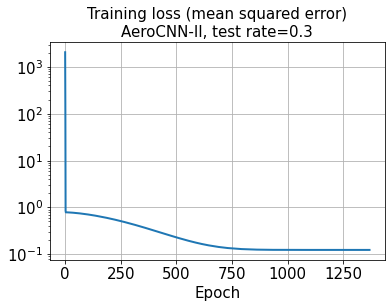

In [30]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

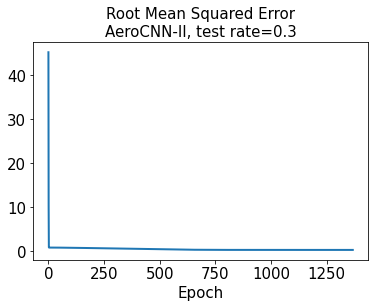

In [31]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nAeroCNN-II, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

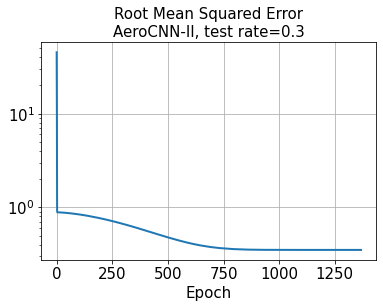

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nAeroCNN-II, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [33]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 9ms/step - loss: 0.1235 - rmse: 0.3514


In [34]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 20ms/step - loss: 0.0939 - rmse: 0.3065


In [35]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 4ms/step


In [36]:
'''model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_AeroCNN_II_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')'''

'model_directory = "D:\\TrainedModels\\20221119"\nif not os.path.exists(model_directory):\n    os.makedirs(model_directory)\nos.chdir(model_directory)\nmodel_name = "20221119steadyValidation_AeroCNN_II_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"\nmodel.save(model_name, overwrite=True, include_optimizer=True, save_format=\'h5\')'

In [37]:
error_train_abs = np.abs(decoded_train - y_train)

In [38]:
error_test_abs = np.abs(decoded_test - y_test)

In [39]:
os.chdir(storage_dir)

In [40]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.39821510953716


In [41]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.3878123384276598


In [42]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.4879106431209302


In [43]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.39807475427471395


In [44]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.48299308265685065


In [45]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.3876952178595327


In [46]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [47]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [48]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [49]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [50]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [51]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

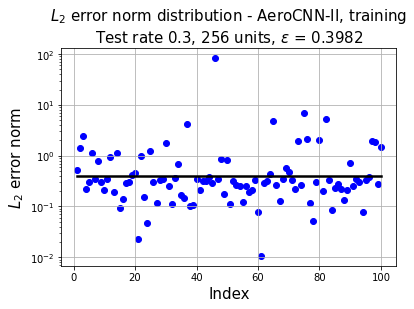

In [52]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

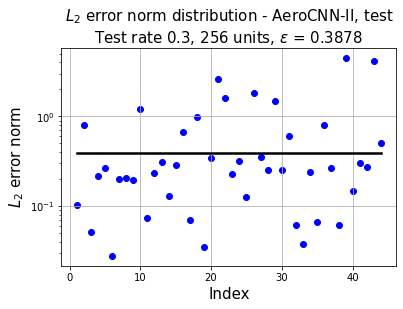

In [53]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                     n_units,
                                                                                                                     l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

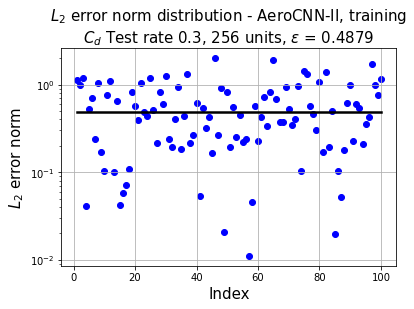

In [54]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

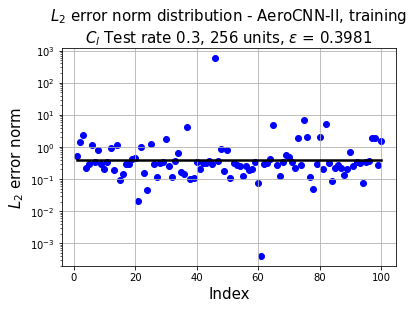

In [55]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

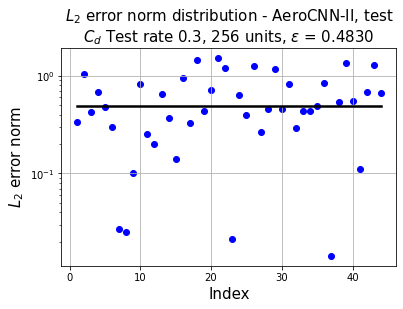

In [56]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

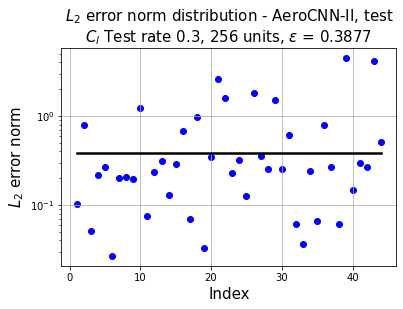

In [57]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()